In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import norm
from torch import optim
from tqdm import tqdm
import torch
import seaborn as sns
import pyro
import numpy.testing as np_testing
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.special import expit, logit
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

sns.set(font_scale=1.5, rc={'figure.figsize':(11.7, 8.27)})

In [2]:
import pyro
from pyro import distributions as distrs

## 1.3 Task: Implementing KL Divergance for a discrete distribution

$$KL ( P||Q ) = \int_{R^n}p(x)\log\left( \frac{p(x)}{q_{\theta}(x)}\right) dx$$

In [3]:
EPS = 1e-8

def compute_kl_divergence(p_probs: torch.Tensor, q_probs: torch.Tensor):
    """"
    KL (P || Q) = \int_{R^n}p(x)\log\left( \frac{p(x)}{q_{\theta}(x)}\right) = 
                = \sum_i p_i log(p_i / q_i)
    
    Note:
        1. The output -- kl_div -- should be one number that is equal to KL (P || Q)
        2. Do not forget to clamp your probabilities to avoid log(0) and (x / 0) problems!
    """
    ### BEGIN SOLUTION
    p_probs, q_probs = p_probs.clamp(min=EPS), q_probs.clamp(min=EPS)
    kl_div = (p_probs * (p_probs / q_probs).log()).sum()
    ### END SOLUTION
    return kl_div

## 1.4 Task: Implementing JS Divergance for a discrete distribution

In [4]:
def compute_js_divergence(p_probs, q_probs):
    """"
    JS (P || Q) = (KL(P || Q) + KL(Q || P)) / 2
    Note:
        1. The output should be one number that is equal to KL (P || Q)
    """
    ### BEGIN SOLUTION
    kl_div = compute_kl_divergence(p_probs, q_probs)
    rkl_div = compute_kl_divergence(q_probs, p_probs)
    ### END SOLUTION
    return (kl_div + rkl_div) / 2

# 2. Fitting 2D-normal distribution

Credits: my collegues that https://github.com/HSE-LAMBDA/DeepGenerativeModels

#### Supplementary functions

In [5]:
def sample_gumbel(shape, eps=1e-20): 
    """
    shape: tuple of ints, i.e. (1, 2) or (54, 7, 3)
    
    Sample from Gumbel(0, 1)
    """
    ### BEGIN SOLUTION
    U = torch.rand(shape)
    sample = -(-(U + eps).log() + eps).log()
    ### END SOLUTION
    return sample

def gumbel_softmax_sample(logits, temperature): 
    """
    logits: [batch_size, num_distributions]torch.Tensor that represents unnormalized log-probs 
             of the batch_size categorical distributions
    temperature: torch.Tensor scalar, temperature of the Gumbel SoftMax Distribution
    
    Draw a sample from the Gumbel-Softmax distribution
    """
    ### BEGIN SOLUTION
    y = logits + sample_gumbel(logits.shape).to(logits)
    g = torch.softmax(y / temperature, dim=-1)
    ### END SOLUTION
    return g

def gumbel_softmax(logits, temperature, hard=False):
    """
    Sample from the Gumbel-Softmax distribution and optionally discretize.
    
    logits: [batch_size, num_distributions] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    
    Returns:
    [batch_size, num_distributions] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    ### BEGIN SOLUTION
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        ind = y.argmax(dim=-1)
        y_hard = torch.zeros_like(y).view(-1, y.shape[-1])
        y_hard.scatter_(1, ind.view(-1, 1), 1)
        y = (y_hard - y).detach() + y
    ### END SOLUTION
    return y

In [6]:
from pyro.distributions import MultivariateNormal
def plot_2d_dots(dots, color='blue', label='None'):
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.scatter(dots[:, 0], dots[:, 1], s=1, c=color, label=label)


def get_parameters(mu=0., sigma=1.):
    train_mu = torch.Tensor([mu, mu]).requires_grad_(True)
    train_sigma = torch.Tensor([[sigma, 0.0],
                                [0.0, sigma]]).requires_grad_(True)
    return train_mu, train_sigma

def create_distr(mu, sigma):
    return distrs.MultivariateNormal(mu, sigma)


def sample(d, num):
    return d.sample(torch.Size([num]))

class MixtureDistribution:
    def __init__(self, p1, p2, w=0.5):
        self._p1 = p1
        self._p2 = p2
        self._w = w
        
    def sample(self, n):
        return torch.cat([sample(self._p1, int(n * self._w)), sample(self._p2, n - int(n * self._w))])
    
    def log_prob(self, x):
        return (EPS + self._w * self._p1.log_prob(x).exp() + (1. - self._w) * self._p2.log_prob(x).exp()).log()


class MixtureDistributionWithGumbel:
    def __init__(self, ps, w, temp=10.):
        self._ps = ps
        self._w = w
        self._temp = temp
        
    def sample(self, n):
        y = gumbel_softmax(self._w.repeat(n, 1), self._temp, hard=True)
        xs = []
        for p in self._ps:
            xs.append(sample(p, n))
        init = torch.zeros_like(xs[0])
        for i, x in enumerate(xs):
            init = init + x * y[:, i].view(-1, 1)
        return init
    
    def log_prob(self, x):
        w = torch.softmax(self._w, 0)
        xs = []
        for p in self._ps:
            xs.append(p.log_prob(x).exp())
        init = torch.zeros_like(xs[0])
        for i, x in enumerate(xs):
            init = init + w[i] * x
        return (init + EPS).log()

## 2. Target distribution

Target distribution is a mixture of two 2-dimensionals normal distributions.

### 2.1 Data Generation

Here we sampling training data from real distribution:


$$D_{train} = \{x\}_{i=1}^{n} \sim p(x)$$

In [7]:
P1 = create_distr(
    mu=torch.Tensor([5, -5]), 
    sigma=torch.Tensor([[1., 0.0], 
                        [0.0, 1.]])
)

P2 = create_distr(
    mu=torch.Tensor([-4, 6]), 
    sigma=torch.Tensor([[1., 0.0], 
                        [0.0, 1.]])
)

P = MixtureDistribution(P1, P2, 0.5)

samples_x = P.sample(1000)
px = P.log_prob(samples_x).exp()

In [8]:
def create_mixture_distr(mus, sigmas, w, temp=1.):
    ds = []
    for mu, sigma in zip(mus, sigmas):
        ds.append(
            create_distr(
                mu=mu, 
                sigma=torch.diag(torch.nn.functional.softplus(torch.diag(sigma))) + 0.1 # dirty hack 1
            )
        )
                  
    return MixtureDistributionWithGumbel(ds, w, temp)


In [9]:
train_mu_1, train_sigma_1 = get_parameters(mu=1, sigma=5)
train_mu_2, train_sigma_2 = get_parameters(mu=-1, sigma=5)
train_mu_3, train_sigma_3 = get_parameters(mu=-1, sigma=5)
w = torch.tensor([0., 0., 0.], requires_grad=True)
Q = create_mixture_distr([train_mu_1, train_mu_2, train_mu_3], [train_sigma_1, train_sigma_2, train_sigma_3], w)

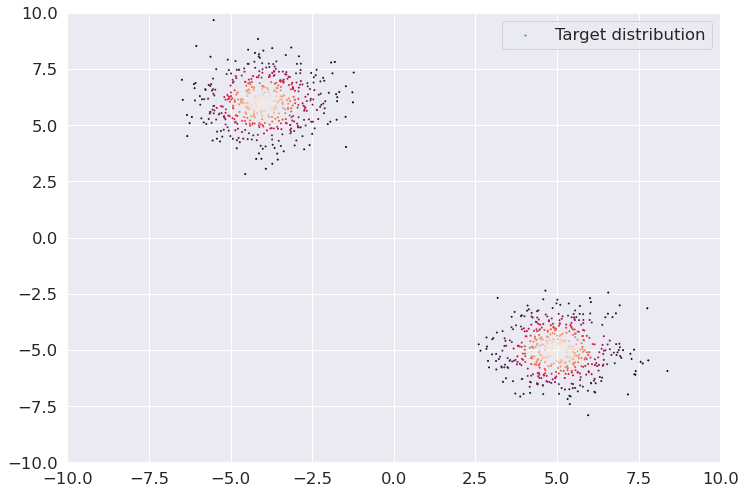

In [10]:
plt.figure()
plot_2d_dots(samples_x, color=px, label='Target distribution')
plt.legend()
plt.show()

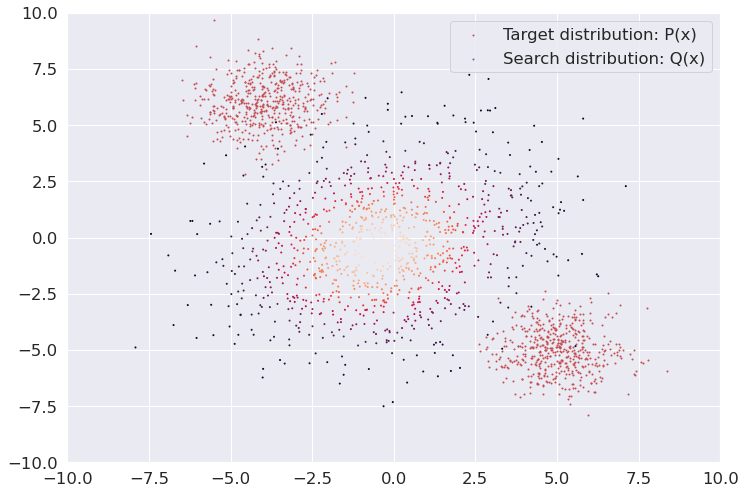

In [11]:
train_mu, train_sigma = get_parameters()

samples_q = Q.sample(1000)
plt.figure()
plot_2d_dots(samples_x, color='r', label='Target distribution: P(x)')
plot_2d_dots(samples_q.detach(), color= Q.log_prob(samples_q).exp().detach(), label='Search distribution: Q(x)')

plt.legend()
plt.show()

In [12]:
samples_q.shape

torch.Size([1000, 2])

### 2.2 Task: optimization of KL

In cases when the only thing you have is the data sampled from real distribution:

$$D_{train} = \{x\}_{i=1}^{n} \sim p(x)$$

To estimate KL divergance you can apply MC estimation. I.e.


$$KL ( P||Q ) = \int_{R^n}p(x)\log\left( \frac{p(x)}{q_{\theta}(x)}\right) dx \approx \sum\limits_{x \in D} p(x) \log\left( \frac{p(x)}{q(x)} \right)$$

In [13]:
def estimate_kl(samples_x, px, mus, sigmas, w, P):
    """
    Here your task is to estimate KL divergance
    
    1. Create Q distribution with parameters train_mu and train_sigma
    2. Estimate qx on samples from real distribution
    3. apply function for KL computation
    """
    ### BEGIN SOLUTION
    Q = create_mixture_distr(mus, sigmas, w)
    qx = Q.log_prob(samples_x).exp()
    loss = compute_kl_divergence(px, qx)
    ### END SOLUTION
    return loss

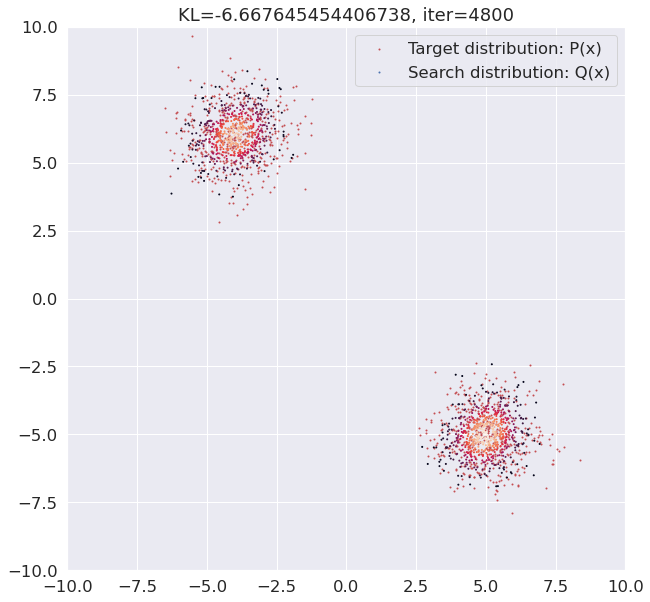

In [14]:
train_mu_1, train_sigma_1 = get_parameters(mu=0, sigma=5)
train_mu_1.grad = torch.zeros_like(train_mu_1)
train_mu_2, train_sigma_2 = get_parameters(mu=-1, sigma=5)
train_mu_3, train_sigma_3 = get_parameters(mu=0, sigma=5)
mus = [train_mu_1, train_mu_2, train_mu_3]
sigmas = [train_sigma_1, train_sigma_2, train_sigma_3]
w = torch.tensor([0.01, 0.02, -0.01], requires_grad=True)
Q = create_mixture_distr(mus, sigmas, w)
ws = []

optim = torch.optim.RMSprop(
    [train_mu_1, train_sigma_1, train_mu_2, train_sigma_2, train_mu_3, train_sigma_3, w], 
    lr=1e-2)

for i in range(5000):
    # Here your task is to 
    # 1. create Q distribution with 
    # 2. calculate p.d.f. of the binomial distribution
    # 3. apply func to true_data and p.d.f. from previous step
    # 4. perform usual backprop
    # Do not forget to zero grad after weights update!

    ### BEGIN SOLUTION
    ws.append(torch.softmax(w, 0))
    optim.zero_grad()
    Q = create_mixture_distr(mus, sigmas, w)

    loss = estimate_kl(samples_x, px, mus, sigmas, w, P)
    if not (train_mu_1.grad == train_mu_1.grad).all():
        print('Failed grad')
        continue
    loss.backward()
    optim.step()
    ### END SOLUTION
    if i % 200 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'KL={loss.item()}, iter={i}')
        plot_2d_dots(samples_x, color='r', label='Target distribution: P(x)')
        samples_q = Q.sample(1000)
        plot_2d_dots(samples_q.detach(), color= Q.log_prob(samples_q).exp().detach(), label='Search distribution: Q(x)')
        plt.legend()
        plt.show()

In [15]:
train_mu_1, train_sigma_1

(tensor([-5.6288,  6.6119], requires_grad=True),
 tensor([[-14.2481,   0.0000],
         [  0.0000,  -3.0758]], requires_grad=True))

In [16]:
train_mu_2, train_sigma_2

(tensor([ 4.9751, -4.9977], requires_grad=True),
 tensor([[-0.6979,  0.0000],
         [ 0.0000, -0.5111]], requires_grad=True))

In [17]:
train_mu_3, train_sigma_3

(tensor([-3.9819,  5.9891], requires_grad=True),
 tensor([[-0.5784,  0.0000],
         [ 0.0000, -0.5645]], requires_grad=True))

In [18]:
torch.softmax(w, 0)

tensor([0.0032, 0.5180, 0.4789], grad_fn=<SoftmaxBackward>)

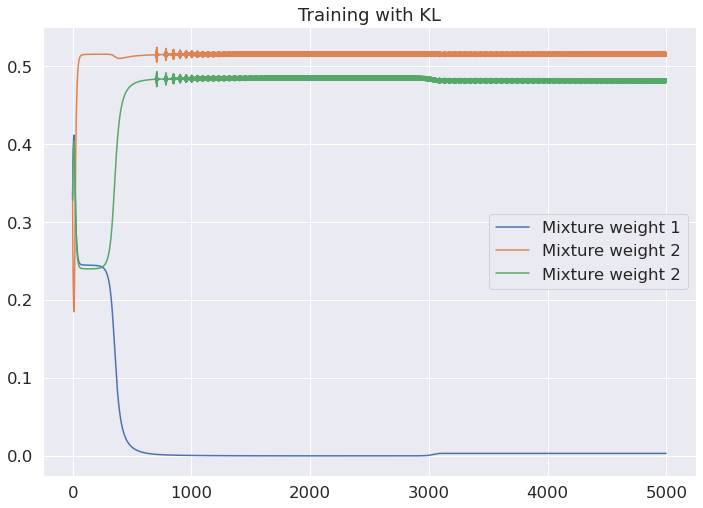

In [19]:
plt.plot(torch.stack(ws)[:, 0].detach(), label='Mixture weight 1')
plt.plot(torch.stack(ws)[:, 1].detach(), label='Mixture weight 2')
plt.plot(torch.stack(ws)[:, 2].detach(), label='Mixture weight 2')
plt.title("Training with KL")
plt.legend()

### Sanity check: 

The search distribution should look like its trying to cover both modes of the target distribution. Like in the lecture :)

### 2.3 Task: optimization of rKL

###### Here you will understand: 
    - the hidden power of Pyro
    - what is wrong with rKL
    
    
    
To estimate rKL divergance you can apply MC estimation. I.e.


$$KL ( P||Q ) = \int_{R^n} q_{\theta}(x) \log\left( \frac{q_{\theta}(x)}{p(x)}\right) dx \approx \sum\limits_{x \in q(x)} q_{\theta}(x) \log\left( \frac{q_{\theta}(x)}{p(x)} \right)$$

###### Note that here we are averaging over samples from q(x)!

In [20]:
def sample(d, num):
    """
    """
    res = pyro.sample("dist", d.expand([num]))
    return res

In [21]:
def estimate_reverse_kl(samples_x, mus, sigmas, w, P, n_samples=2000):
    """
    Here your task is to estimate rKL divergance
    
    1. Create Q distribution with parameters train_mu and train_sigma
    2. Sample(!) points x_q from Q distribution
    3. Estimate p(x_q)
    4. Estimate q(x_q)
    3. apply function for KL computation
    """
    ### BEGIN SOLUTION
    Q = create_mixture_distr(mus, sigmas, w)
    q = Q.sample(n_samples)
    px = P.log_prob(q).exp()
    qx = Q.log_prob(q).exp()
    loss = compute_kl_divergence(qx, px)
    ### END SOLUTION
    return loss

In [22]:
EPS = 1e-5

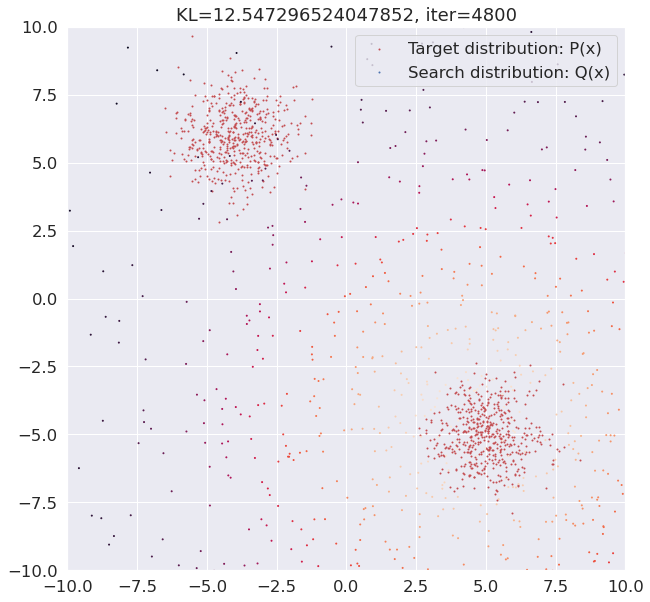

In [23]:
train_mu_1, train_sigma_1 = get_parameters(mu=0, sigma=5)
train_mu_1.grad = torch.zeros_like(train_mu_1)
train_mu_2, train_sigma_2 = get_parameters(mu=-1, sigma=5)
train_mu_3, train_sigma_3 = get_parameters(mu=0, sigma=5)
mus = [train_mu_1, train_mu_2, train_mu_3]
sigmas = [train_sigma_1, train_sigma_2, train_sigma_3]
w = torch.tensor([0.01, 0.02, -0.01], requires_grad=True)
Q = create_mixture_distr(mus, sigmas, w)
ws = []

optim = torch.optim.RMSprop(
    [train_mu_1, train_sigma_1, train_mu_2, train_sigma_2, train_mu_3, train_sigma_3, w], 
    lr=1e-2)


for i in range(5000):
    ws.append(torch.softmax(w, 0))
    optim.zero_grad()
    Q = create_mixture_distr(mus, sigmas, w)
    loss = estimate_reverse_kl(samples_x, mus, sigmas, w, P)
    loss.backward()
    if not (train_mu_1.grad == train_mu_1.grad).all():
        print('Failed grad')
        continue
    optim.step()
    if i % 200 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'KL={loss.item()}, iter={i}')
        plot_2d_dots(samples_x, color='r', label='Target distribution: P(x)')
        samples_q = Q.sample(1000)
        plot_2d_dots(samples_q.detach(), color=Q.log_prob(samples_q).exp().detach(), label='Search distribution: Q(x)')
        plt.legend()
        plt.show()

In [24]:
train_mu_1, train_sigma_1

(tensor([-3.7206,  6.0848], requires_grad=True),
 tensor([[ 0.6693,  0.0000],
         [ 0.0000, -0.8916]], requires_grad=True))

In [25]:
train_mu_2, train_sigma_2

(tensor([ 4.6426, -4.6648], requires_grad=True),
 tensor([[50.5077,  0.0000],
         [ 0.0000, 50.5671]], requires_grad=True))

In [26]:
train_mu_3, train_sigma_3

(tensor([-3.5358,  5.6260], requires_grad=True),
 tensor([[-1.1861,  0.0000],
         [ 0.0000, -1.7116]], requires_grad=True))

In [27]:
torch.softmax(w, 0)

tensor([4.9684e-08, 1.0000e+00, 5.7512e-08], grad_fn=<SoftmaxBackward>)

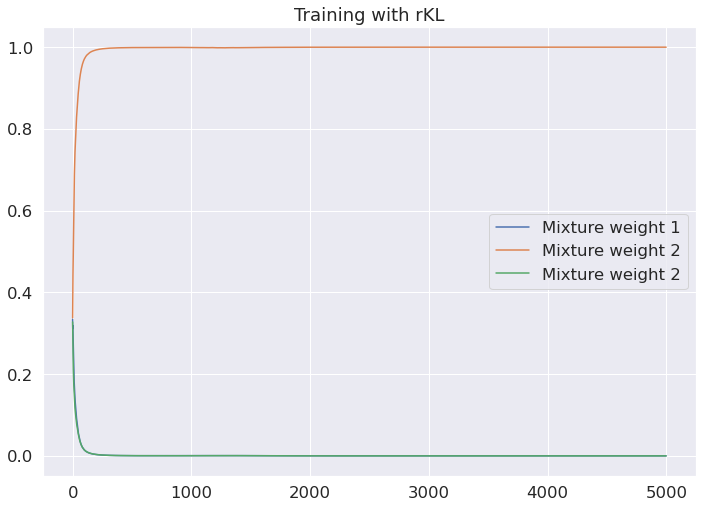

In [29]:
plt.plot(torch.stack(ws)[:, 0].detach(), label='Mixture weight 1')
plt.plot(torch.stack(ws)[:, 1].detach(), label='Mixture weight 2')
plt.plot(torch.stack(ws)[:, 2].detach(), label='Mixture weight 2')
plt.title("Training with rKL")
plt.legend()